In [39]:
import os # for detecting CPU cores
import numpy as np
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from icecream import ic

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [40]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "06_DL_model_submission" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 8


In [41]:
import urllib, requests #for Telegram notifications

def send_telegram_message(message):
    """Sending messages to Telegram bot via requests.get()."""
    
    message = f"{FILENAME_NB}:\n{message}"

    # Using "try and except" to ensure that the notebook execution will not be stopped only because of problems with the bot.
    # Example: No network connection.
    # ISSUE: Be careful, an error messages will leak your Telegram Bot Token when uploaded to GitHub.
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=%s&text=%s'%(token, chat_id, urllib.parse.quote_plus(message))
        _ = requests.get(url, timeout=10)
    
    except Exception as e:
        print('\n\nSending message to Telegram Bot was not successful.\n\n')
        print(e)
        
    return None

In [42]:
train_df = pd.read_pickle(PATH_DATA_INT+'train-opt.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt.pkl')
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [43]:
features_num = train_df.drop(['id','target'], axis=1).columns
feature_cols = features_num.to_list()
X = train_df.drop(['id','target'], axis=1).copy()
y = train_df['target'].copy()
X_test = test_df.drop(['id'], axis=1).copy()

X.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.106643,3.59437,132.804001,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,0.010739,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496
1,0.125021,1.67336,76.533600,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,0.135838,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719
2,0.036330,1.49747,233.546005,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,0.117310,4.88300,0.085222,0.032396,0.116092,-0.001689,-0.520069,2.14112,0.124464,0.148209
3,-0.014077,0.24600,779.966980,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,-0.015347,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873
4,-0.003259,3.71542,156.128006,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,0.013781,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798


In [44]:
from sklearn.preprocessing import StandardScaler

# Scaling all values
s_scaler = StandardScaler()
for col in feature_cols:
    X[col] = s_scaler.fit_transform(np.array(X[col]).reshape(-1,1))
    X_test[col] = s_scaler.transform(np.array(X_test[col]).reshape(-1,1))

X.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.382553,0.705771,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,...,-0.537157,-0.872508,-0.258806,-0.595537,-0.199502,-0.196145,1.067358,-0.400887,-0.167145,0.443374
1,-0.347377,-0.530387,-0.417061,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,...,0.573313,0.658473,-0.252018,0.548089,0.019765,2.392937,-1.806811,-0.008064,-0.412110,-0.371198
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,...,0.408845,1.580886,-0.127714,-0.226174,-0.062423,-0.516946,-1.968603,-0.294434,-0.078904,0.094984
3,-0.613619,-1.448884,0.857867,-0.490286,-0.409357,-0.656445,-0.001055,1.255833,1.281843,-0.025780,...,-0.768719,0.667692,-0.314304,-0.565262,-0.179472,-0.311897,-1.306572,-0.407556,-0.272505,-0.295118
4,-0.592913,0.783666,-0.272802,-0.323841,-0.382205,-0.293270,0.930480,-1.684456,0.543499,-0.237512,...,-0.510155,-0.346112,-0.361423,0.386926,-0.042986,-0.329511,-0.965117,-0.993613,-0.393636,-0.189697


# Feature Engineering

## KMeans Clustering

In [45]:
from sklearn.cluster import KMeans

n_clusters_1 = 9
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters_1)]
#kmeans = KMeans(n_clusters=n_clusters_1, n_init=50, max_iter=500, random_state=rnd_state)
kmeans = KMeans(n_clusters=n_clusters_1, init="k-means++", max_iter=500, random_state=rnd_state)

ic(n_clusters_1);
#ic(cluster_cols);

ic| n_clusters_1: 9


In [46]:
# cluster distance instead of cluster number

# train
X_cd = kmeans.fit_transform(X[feature_cols])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=train_df.index)
X = X.join(X_cd)

# test
X_cd = kmeans.transform(X_test[feature_cols])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=test_df.index)
X_test = X_test.join(X_cd)

In [47]:
feature_cols += cluster_cols
ic(len(feature_cols));
X.head()

ic| len(feature_cols): 109


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f99,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9
0,-0.382553,0.705771,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,...,0.443374,13.524524,13.255687,13.700806,14.274994,12.859630,12.957320,36.129147,14.155483,13.117831
1,-0.347377,-0.530387,-0.417061,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,...,-0.371198,10.190652,9.777174,10.614064,11.234878,10.152011,9.488068,35.085693,10.948878,10.155034
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,...,0.094984,8.555525,7.960729,8.872967,9.686649,8.570546,7.778075,34.809380,9.578272,8.652298
3,-0.613619,-1.448884,0.857867,-0.490286,-0.409357,-0.656445,-0.001055,1.255833,1.281843,-0.025780,...,-0.295118,16.142862,15.755400,16.347662,16.765732,16.229053,15.869077,37.083992,16.634487,16.166260
4,-0.592913,0.783666,-0.272802,-0.323841,-0.382205,-0.293270,0.930480,-1.684456,0.543499,-0.237512,...,-0.189697,8.511835,7.657890,8.973676,9.729104,8.658287,8.013620,34.997364,9.153749,8.548615


## Polynomial Features


In [48]:
from sklearn.preprocessing import PolynomialFeatures


In [49]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

X_poly = poly.fit_transform(X[cluster_cols])
T_poly = poly.transform(X_test[cluster_cols])

poly_cols = [f"cluster_poly{i+1}" for i in range(X_poly.shape[1])]

X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=X.index)
T_poly_df = pd.DataFrame(T_poly, columns=poly_cols, index=X_test.index)

X = pd.concat([X, X_poly_df], axis=1)
X_test = pd.concat([X_test, T_poly_df], axis=1)


In [50]:
feature_cols += poly_cols
ic(len(feature_cols));
X.head()

ic| len(feature_cols): 155


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster_poly37,cluster_poly38,cluster_poly39,cluster_poly40,cluster_poly41,cluster_poly42,cluster_poly43,cluster_poly44,cluster_poly45,cluster_poly46
0,-0.382553,0.705771,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,...,166.626343,464.607452,182.034271,168.690445,468.136932,183.417130,169.971939,511.425537,473.936035,185.689240
1,-0.347377,-0.530387,-0.417061,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,...,96.322968,356.190338,111.153130,103.094017,332.895416,103.883698,96.351646,384.148987,356.296417,111.186234
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,...,66.662346,298.335388,82.091019,74.154922,270.749969,74.500511,67.298218,333.413696,301.181122,82.874062
3,-0.613619,-1.448884,0.857867,-0.490286,-0.409357,-0.656445,-0.001055,1.255833,1.281843,-0.025780,...,257.540100,601.838074,269.961975,262.363098,588.488708,263.973938,256.543610,616.873169,599.509460,268.917450
4,-0.592913,0.783666,-0.272802,-0.323841,-0.382205,-0.293270,0.930480,-1.684456,0.543499,-0.237512,...,69.384224,303.017212,79.255783,74.016365,280.455597,73.354668,68.505356,320.357056,299.179016,78.251877


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_num = make_pipeline(StandardScaler(),)

preprocessor = make_column_transformer((transformer_num, feature_cols))

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, train_size=0.75, random_state=rnd_state
)

# X_train = preprocessor.fit_transform(X_train)
# X_valid = preprocessor.transform(X_valid)
# X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
print(input_shape)


[155]


# Model Training

In [13]:
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
batch_size = 502
learning_rate = 0.00012239884711399426
patience = 57
n_units_l0 = 3
n_units_l1 = 3
epochs = 2000


In [25]:
gc.collect()

# Set seed
tf.random.set_seed(rnd_state)

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=input_shape),
        #layers.Dense(n_units_l0, activation="relu"),
        #layers.Dense(n_units_l1, activation="relu"),
        layers.Dense(n_units_l0, activation="swish"),
        layers.Dense(n_units_l1, activation="swish"),
        layers.Dense(1, activation="sigmoid"),  # sigmoid for binary output
    ]
)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy", # for binary classification 
    metrics=["AUC"],
)

early_stopping = EarlyStopping(patience=patience, min_delta=learning_rate, monitor='val_auc', restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    #shuffle=True
    verbose=0,  # hide the output because we have so many epochs
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 155)              620       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 3)                 468       
                                                                 
 dense_10 (Dense)            (None, 3)                 12        
                                                                 
 dense_11 (Dense)            (None, 1)                 4         
                                                                 
Total params: 1,104
Trainable params: 794
Non-trainable params: 310
_________________________________________________________________


In [26]:
# Evaluate the model accuracy on the validation set.
score = model.evaluate(X_valid, y_valid, verbose=0)

print(score[1])

0.7543720006942749


Best Validation Loss: 0.568476
Best Validation AUC: 0.754474


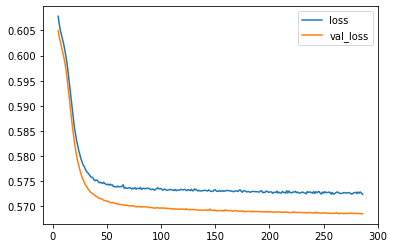

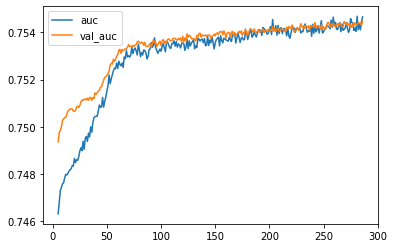

In [27]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ["loss", "val_loss"]].plot()
history_df.loc[5:, ["auc", "val_auc"]].plot()

print(
    ("Best Validation Loss: {:0.6f}" + "\nBest Validation AUC: {:0.6f}").format(
        history_df["val_loss"].min(), history_df["val_auc"].max()
    )
)


# SGD:
# Best Validation Loss: 0.565582
# Best Validation Accuracy: 0.750882

# ADAM:
# 06 Clusters PF-Degree 2: 0.755635
# 08 Clusters PF-Degree 2: 0.755701
# 08 Clusters PF-Degree 3: 0.754991
# 09 Clusters PF-Degree 2: 0.755704 
# 09 Clusters PF-Degree 2: 0.755857 ** (learning rate = 0.0001)
# 10 Clusters PF-Degree 2: 0.755059

# 09 Clusters PF-Degree 2: OPT: 0.756616 | Kaggle: 0.74796

In [28]:
best_score = 0
best_score = history_df["val_auc"].max()
ic(best_score)

message = f'New baseline score: {best_score}'
send_telegram_message(message)

ic| best_score: 0.7544742822647095


In [29]:
preds_test = model.predict(X_test)

# Submitting Results

In [30]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

#mlflow_run_id = str(run.info.run_id)
objective = "DL-2layer-FE-opt"

curr_submission_fn = f"{now}_submission_{objective}.csv"

sample_df['target'] = preds_test
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)

2021-11-12_submission_DL-2layer-FE-opt.csv


In [31]:
sample_df.tail()

,id,target
539995,1139995,0.754018
539996,1139996,0.730101
539997,1139997,0.635519
539998,1139998,0.733412
539999,1139999,0.724752


In [32]:
#!kaggle competitions submit tabular-playground-series-nov-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}

https://machinelearningapplied.com/hyperparameter-search-with-optuna-part-3-keras-cnn-classification-and-ensembling/

# Testing new Model

In [51]:
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.backend import clear_session

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score

In [52]:
X_nn = X.copy()
X_test_nn = X_test.copy()
# X_nn["linear_preds"] = linear_oof_preds
# X_test_nn["linear_preds"] = linear_test_preds
# Scaling all values
mm_scaler = MinMaxScaler()
for col in X_nn.columns:
    X_nn[col] = mm_scaler.fit_transform(np.array(X_nn[col]).reshape(-1,1))
    X_test_nn[col] = mm_scaler.transform(np.array(X_test_nn[col]).reshape(-1,1))

In [53]:
X_nn.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster_poly37,cluster_poly38,cluster_poly39,cluster_poly40,cluster_poly41,cluster_poly42,cluster_poly43,cluster_poly44,cluster_poly45,cluster_poly46
0,0.310367,0.646697,0.248101,0.577060,0.286635,0.306885,0.626685,0.470543,0.437860,0.268236,...,0.014472,0.029369,0.015020,0.014219,0.030110,0.015879,0.015047,0.032175,0.028565,0.015516
1,0.311828,0.388867,0.241034,0.601646,0.288154,0.815037,0.305376,0.107503,0.758411,0.270864,...,0.006808,0.018038,0.007292,0.007050,0.015973,0.007210,0.007002,0.018852,0.016215,0.007375
2,0.304777,0.365259,0.260754,0.451589,0.281835,0.559115,0.799909,0.680494,0.398849,0.272862,...,0.003574,0.011991,0.004124,0.003888,0.009477,0.004007,0.003828,0.013541,0.010429,0.004281
3,0.300770,0.197292,0.329385,0.413095,0.280095,0.351457,0.491403,0.769063,0.752827,0.279748,...,0.024383,0.043712,0.024605,0.024456,0.042691,0.024659,0.024506,0.043213,0.041747,0.024612
4,0.301630,0.662944,0.251031,0.445679,0.281083,0.425300,0.681947,0.164935,0.604515,0.270498,...,0.003871,0.012480,0.003815,0.003873,0.010492,0.003882,0.003960,0.012174,0.010219,0.003776


In [54]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weights_dict={}
for label in np.sort(y.unique()):
    class_weights_dict[label] = class_weights[label]
    
class_weights_dict

{0: 1.0121662381829593, 1: 0.9881227643722456}

In [55]:
X.shape[1]

155

In [56]:
# Clear clutter from previous Keras session graphs.
clear_session()
gc.collect()

141

In [57]:
def get_nn_model():
    """
    Builds and returns a sequential NN model along with its callbacks.
    """
    model = keras.models.Sequential()
    # An input layer
    model.add(keras.layers.Input(shape=[X.shape[1],]))
    # Hidden layers
    model.add(keras.layers.Dense(64, kernel_initializer=keras.initializers.GlorotNormal, activation="swish")) #64
    keras.layers.Dropout(0.2),
    model.add(keras.layers.Dense(32, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    keras.layers.Dropout(0.2),
    model.add(keras.layers.Dense(16, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    keras.layers.Dropout(0.2),
    model.add(keras.layers.Dense(8, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    keras.layers.Dropout(0.2),
    #model.add(keras.layers.Dense(4, kernel_initializer=keras.initializers.GlorotNormal, activation="swish"))
    #keras.layers.Dropout(0.2),
    # An output layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Checking layers setup
    model.summary()

    # A callback to stop training when overfitting is detected
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

    # A callback to reduce learning rate when plateau is detected
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
                monitor='val_auc', factor=0.2, patience=5, verbose=0,
                min_lr=0.00001, mode='min')

    # Compiling a model
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001), #0.001
                  metrics=['AUC', 'FalsePositives', 'FalseNegatives', 'BinaryAccuracy']
                 )
    return model, early_stopping_cb, reduce_lr

In [58]:
# Fold splitting parameters
splits = 5
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

# Two zero-filled arrays for out-of-fold and test predictions
nn_oof_preds = np.zeros((X_nn.shape[0],))
nn_test_preds = np.zeros((X_test_nn.shape[0],))
total_mean_auc = 0

# Generating folds and making training and prediction for each of them
for num, (train_idx, valid_idx) in enumerate(skf.split(X_nn, y)):
    clear_session()
    gc.collect()
    print(f"\n===Training with fold {num}")
    X_train, X_valid = X_nn.loc[train_idx], X_nn.loc[valid_idx]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

    nn_model, early_stopping_cb, reduce_lr = get_nn_model()
    history = nn_model.fit(X_train, y_train, epochs=30,
                            validation_data=(X_valid, y_valid), 
                            callbacks=[early_stopping_cb, reduce_lr],
                            class_weight=class_weights_dict
                           )
    
    # Getting validation data predictions. Each fold model makes predictions on an unseen data.
    # So in the end it will be completely filled with unseen data predictions.
    # It will be used to evaluate hyperparameters performance only.    
    nn_oof_preds[valid_idx] = nn_model.predict(X_valid).flatten()
    
    # Getting mean test data predictions (i.e. devided by number of splits)
    nn_test_preds += nn_model.predict(X_test_nn).flatten() / splits
    
    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, nn_oof_preds[valid_idx])
    print(f"\n=== Fold {num} ROC AUC: {fold_auc} ===")
    
    # Getting mean score of all fold models (i.e. devided by number of splits)
    total_mean_auc += fold_auc / splits

print(f"\nOverall ROC AUC: {total_mean_auc}")


===Training with fold 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                9984      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
15000/15000 [===

KeyboardInterrupt: 

# Results
- 5 layers: 64, 32, 8,4 AUC: 0.7536374249876355 | 0.74771

In [ ]:
predictions = pd.DataFrame()
predictions["id"] = test_df["id"].astype(int)
predictions["target"] = nn_test_preds

predictions.to_csv('submission.csv', index=False, header=predictions.columns)
predictions.head()

,id,target
0,600000,0.741963
1,600001,0.738693
2,600002,0.747105
3,600003,0.363046
4,600004,0.709745


In [ ]:
nn_test_preds

array([0.74196276, 0.73869251, 0.74710482, ..., 0.72205471, 0.73356397,
       0.7455571 ])

In [ ]:
#!kaggle competitions submit tabular-playground-series-nov-2021 -f submission.csv -m ''

Successfully submitted to Tabular Playground Series - Nov 2021



  0%|          | 0.00/14.2M [00:00<?, ?B/s]
  1%|          | 80.0k/14.2M [00:00<00:20, 729kB/s]
  1%|▏         | 184k/14.2M [00:00<00:17, 838kB/s] 
  2%|▏         | 272k/14.2M [00:00<00:27, 528kB/s]
  2%|▏         | 336k/14.2M [00:00<00:30, 477kB/s]
  3%|▎         | 392k/14.2M [00:00<00:33, 436kB/s]
  3%|▎         | 440k/14.2M [00:00<00:36, 391kB/s]
  3%|▎         | 488k/14.2M [00:01<00:36, 395kB/s]
  4%|▎         | 528k/14.2M [00:01<00:36, 389kB/s]
  4%|▍         | 568k/14.2M [00:01<00:37, 383kB/s]
  4%|▍         | 608k/14.2M [00:01<00:37, 380kB/s]
  4%|▍         | 648k/14.2M [00:01<00:37, 376kB/s]
  5%|▍         | 688k/14.2M [00:01<00:38, 371kB/s]
  5%|▌         | 728k/14.2M [00:01<00:37, 371kB/s]
  5%|▌         | 768k/14.2M [00:02<01:23, 169kB/s]
  6%|▋         | 920k/14.2M [00:02<00:37, 370kB/s]
  7%|▋         | 984k/14.2M [00:02<00:37, 371kB/s]
  7%|▋         | 1.02M/14.2M [00:02<00:36, 374kB/s]
  8%|▊         | 1.07M/14.2M [00:02<00:37, 366kB/s]
  8%|▊         | 1.12M/14.2M [00: